<a href="https://colab.research.google.com/github/hyunshoon/bitcoin_price_prediction_with_sentiment/blob/main/comments_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reddit comments EDA
1. Setting
2. data load, pre-processing
3. Sentiment EDA using VADER
4. Sentiment EDA using Bert
5. EDA between sentiment and price


# Setting

In [1]:
try:
  import colab
  !pip install --upgrade pip
except:
  pass

     |████████████████████████████████| 2.1 MB 16.8 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [15]:
print('Installing TensorFlow Data Validation')
!pip install --upgrade 'tensorflow_data_validation[visualization]<2'
!pip install vaderSentiment
!pip install pysentimiento

Installing TensorFlow Data Validation
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.1/312.1 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 KB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.2/895.2 KB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.3/596.3 KB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [28]:
import tensorflow as tf
import pkg_resources
import importlib
importlib.reload(pkg_resources)
import tensorflow_data_validation as tfdv
print('TF version:', tf.__version__)
print('TFDV version:', tfdv.version.__version__)

from google.colab import drive
import re
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix
import sklearn.metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
from datetime import datetime, timedelta

from transformers import pipeline
from pysentimiento import create_analyzer
import pickle

TF version: 2.8.0
TFDV version: 1.7.0


In [18]:
drive.mount('/content/drive')
path_vader = '/usr/local/lib/python3.7/dist-packages/vaderSentiment/'
path_capstone = '/content/drive/MyDrive/Colab Notebooks/capstone/data/'
print(os.listdir(path_vader))
print(os.listdir(path_capstone))

#lexicon update
shutil.copy(f'{path_capstone}emoji_utf8_lexicon.txt', f'{path_vader}emoji_utf8_lexiconss.txt')
shutil.copy(f'{path_capstone}vader_lexicon_v3.txt', f'{path_vader}vader_lexicon.txt')

analyzer = SentimentIntensityAnalyzer()#vader analyzer
analyzer_bert = create_analyzer(task="sentiment", lang="en")#bert analyzer

#현재 최종수정본 날짜를 보면 수정이 되는데 inflation 단어가 없다.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['vaderSentiment.py', '__pycache__', 'vader_lexicon.txt', 'emoji_utf8_lexiconss.txt', 'emoji_utf8_lexicon.txt', '__init__.py']
['data_reddit.csv', 'btc_day_price.csv', 'emoji_utf8_lexicon.txt', 'sentences_948.xlsx', 'new_lexicon.csv', 'all_text_sentiment.csv', 'feature.csv', 'feature_v2.csv', 'feature_v3.csv', 'feature_v4_filtering_long_sentences.csv', 'feature_v5_filter_low_abs_comp.csv', 'list_2words.pkl', 'data_final_crypto.csv', 'vader_lexicon_v3.txt', 'second_comment_bitcoin_cl.csv', 'top_comment_bitcoin_cl.csv', 'data_final_bitcoin.csv', 'ohlcv.csv']


Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/890 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/515M [00:00<?, ?B/s]

# comment count

### load comment data

In [5]:
df_btc = pd.read_csv(f'{path_capstone}data_final_bitcoin.csv', index_col=0)
df_btc = df_btc.loc[:,'2017-12-02':]
df_btc.fillna(0, inplace=True)

df_btc_top = pd.read_csv(f'{path_capstone}top_comment_bitcoin_cl.csv', index_col=0)
df_btc_top = df_btc_top.loc[:,'2017-12-02':]
df_btc_top.fillna(0, inplace=True)

df_btc_second = pd.read_csv(f'{path_capstone}second_comment_bitcoin_cl.csv', index_col=0)
df_btc_second = df_btc_second.loc[:,'2017-12-02':]
df_btc_second.fillna(0, inplace=True)

df_btc

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

,2017-12-02,2017-12-03,2017-12-05,2017-12-06,2017-12-08,2017-12-09,2017-12-10,2017-12-12,2017-12-13,2017-12-14,...,2022-03-04,2022-03-05,2022-03-06,2022-03-07,2022-03-08,2022-03-09,2022-03-10,2022-03-11,2022-03-12,2022-03-13
0,$4 transaction fee for miners to validate your...,/r/BitcoinMarkets,Google dumpprivkey\n\nYou can export the priv...,Bitcoin.de,*giggles nervously*,\n\nCBOE\n\nhttp://cfe.cboe.com/cfe-products/x...,December 1st moron at your service.,.,I sell the dips and buy the Hills. FML,$5000 per satoshi,...,#getOffZero,1000 bucks is like 2.5%. Shouldn't be worried ...,10% chance the world ends in the next 12 months,"\nYeah, Bitcoin is the new turtleneck, no long...","""No diff"", lol\n\nYep that's the only selling ...",$42069 nice.,$37K here it comes,"Aha found someone mention it below, my bad",39k seems to be the base level for the past co...,$50k by this time next Sunday. \nSo say we al...
1,/u/tip_bit /u/MrRFT123 0.05\n\nWelcome to the ...,10% seriously thinking of doubling down tho,"""Time in the market is more important than tim...",I feel like I'm in a bitcoin casino here!! Fo...,/r/cringe,futures are good for btc,#DONT\n\n#STOP\n\n#ME\n\n#NOW\n\n#ᕕ( ᐛ )ᕗ ᕕ( ᐛ...,"17,250 is trying to keep the top on this thing",time to panic buy .,1 - 2 years maybe,...,38k is big support. If fail then hello 20s,40k and smooth sailing to 50k 😎,All TA is BS,I agree with you.,*Laughs in TDI*,$69k on your birthday sounds like a good deal,10k sats per gallon now,"And it's gonna remain this way, nothing changi...","Agreed on this, you're not the only one.",22% of Americans do not own Bitcoin. Calling BS
2,4 million USD.,15k within 2 days.. short squeeze in progress.\n,$12100,!remindme in 2 hours,10/10 technical analysis you should start a bl...,$1000,"#FFS PEOPLE, BUY AND HODL!",18K we are here!!!!!,"""redditor for 2 days"" people",5 bucks a day is about average for a 1080ti. G...,...,40k,A Bullrog of Morgoth.,Also…not a priority for majority of voters,Not a bad day considering the Nasdaq is down ...,20/200 EMA crossed on the 30 min. Bulls in con...,38k in less than 24 hours,5 years since 2017 and we're at 38k.,"BTC is a need for many, not just an investment...","Back then things were pretty good indeed, can'...",3 minutes to drop a cool grand lol
3,Binance.,1btc =9000 pounds on gdax!!,...welp,"""Bitcoin purchases are temporarily disabled"" o...",100% not going to happen. It's a gamble eithe...,$10K maybe.,#litecoingang\n,18K!!!!!!!!!!!!!,"$16,230. Just enough to piss you off, not enou...",A gateway error just usually means the server ...,...,950k,Always a good time to DCA some BTC.,Always a better solution indeed to hodl to you...,Swing mood in this chat is quite remarkable,"39k , not bad for a bear market",50 percent usd is something that I'm not comfo...,"50k looks so far after, we saw the barrier of ...",BTC is my lavish retirement. But I max out my ...,"Both are good, it's just that trezor is open s...",38 to 40k. Its been now 15 weeks since 65k. I ...
4,Bitconnect is a scam. Steer clear,> 100% for all those with mortgages.,"11,840 and steadily climbing. Looks like it wi...","""Purchases disabled"" on coinbase OKAY",10k is coming,$15k seems to be a support level.. i’m not big...,**17k inbound**,"18K, Hodl Hodl Hodl buy more, 19K, hodl hodl h...","$800 is less than 5% of bitcoins price, yall n...",BATTLE OF THE WALLS,...,A divided Korea was the unintended consequence...,Anyone think there's a big low coming possibly...,"B cash is dying slowly , and everyone knows th...",1 BTC = 1 BTC,40 🥳,"> then jump another $55k\n\nLol, I think you s...","A little from column A, a little from column B",Bitcoin ATMs declared illegal and shut down in...,Cause nothing has happened in more than a year,"Already buying it up sir, gonna buy all the di..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2291,0,0,0,0

In [6]:
def count_text_num(df):#count daily comment num
  day_cnt = []
  for i in range(len(df.columns)):
    cnt = 0
    for j in range(len(df)):
      text = df.iloc[j,i]
      if text =='[deleted]' or text == 0: continue #NaN, [deleted]되있는 문장 스킵
      cnt +=1
    if cnt==0:
      print('0개인 날')
    day_cnt.append(cnt)
  return day_cnt

In [7]:
btc_cnt = count_text_num(df_btc)
btc_cnt_top = count_text_num(df_btc_top)
btc_cnt_second = count_text_num(df_btc_second)

0개인 날
0개인 날
0개인 날
0개인 날
0개인 날
0개인 날
0개인 날
0개인 날


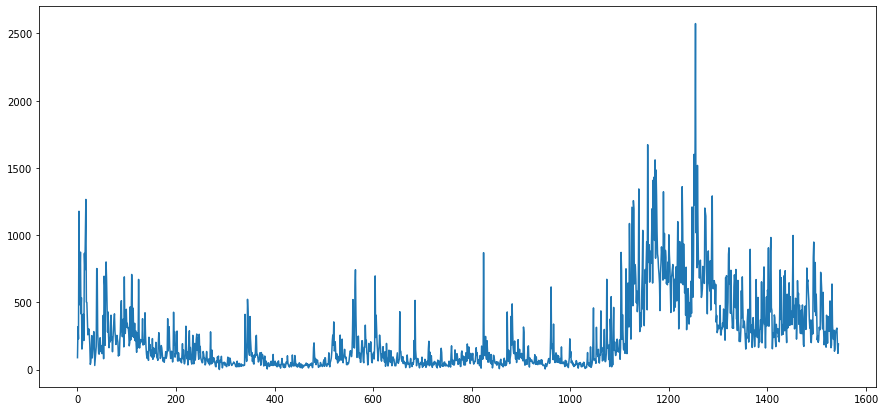

In [8]:
plt.figure(figsize=(15,7))
plt.plot(btc_cnt)

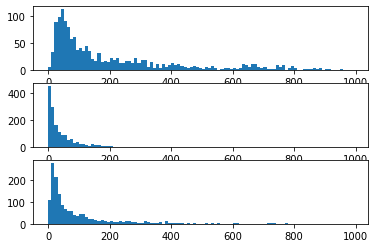

In [9]:
plt.subplot(3, 1, 1)
plt.hist(btc_cnt, bins= range(0,1000,10))
plt.subplot(3, 1, 2)
plt.hist(btc_cnt_top, bins= range(0,1000,10))
plt.subplot(3, 1, 3)
plt.hist(btc_cnt_second, bins= range(0,1000,10))
plt.show()

# sentiment EDA

In [19]:
def sent(x):
    if x > 0:
        return 'positive'
    elif x == 0:
        return 'neutral'
    else:
        return 'negative'

def sentiment_bi(probas):
    if probas['POS'] > probas['NEG']:
        return 'positive'
    else:
        return 'negative'

In [30]:
def filtering(series): #text filtering
  cleaned = []
  for text in series: 
    if text =='[deleted]' or text == 0: continue #NaN, [deleted]되있는 문장 스킵
    if re.search('http|[!gif]', text): continue
    length = len(text.split())#20단어 이상 문장들, 물음표로 끝나는 문장 제거
    if length >20 or text[-1]=='?': continue
    cleaned.append(text)
  return cleaned

In [31]:
#감성점수 비율 계산
def ratio(li):
  neu = 0
  pos = 0
  neg = 0
  for s in li:
    if s == 'neutral':
      neu += 1
    elif s== 'positive':
      pos += 1
    else:
      neg += 1
  total = pos + neu + neg
  if total!=0:
    return [pos/total, neu/total, neg/total]
  else:
    return [0,0,0]

In [32]:
def make_day_score(df):
  day = []
  date = []
  for i in range(1,len(df.columns)):
    cleaned = filtering(df.iloc[:,i])
    date.append(df.columns[i].replace('-',''))
    sentiments = []
    compounds = []
    for i, text in enumerate(cleaned):# 정제된 데이터에서 긍/중/부 판단
      comp = analyzer.polarity_scores(text)['compound']
      # if abs(comp)<0.1: continue
      sentiments.append(sent(comp))
      # compounds.append(analyzer.polarity_scores(cleaned[i])['compound'])
      compounds.append(comp)
    sent_features = ratio(sentiments)
    sent_features.append(np.mean(compounds))
    sent_features.append(np.var(compounds))
    day.append(sent_features)
  day = pd.DataFrame(day, columns=['pos', 'neu', 'neg', 'mean', 'var'])
  day['day'] = date
  for i in range(len(day)):
    day.loc[i,'day'] = datetime.strptime(day.loc[i,'day'], '20%y%m%d')
  day.set_index('day', inplace =True)
  return day


In [33]:
def make_day_score_bert(df):
  day = []
  date = []
  for i in range(1,len(df.columns)):
    cleaned = filtering(df.iloc[:,i])
    date.append(df.coluxmns[i].replace('-',''))
    sentiments = []
    for i, text in enumerate(cleaned):# 정제된 데이터에서 긍/중/부 판단
      sentiments.append(analyzer_bert.sentiment_bi(analyzer.predict(x).probas))
    day.append(sentiments)
  day = pd.DataFrame(day, columns=['pos', 'neg'])
  day['day'] = date
  for i in range(len(day)):
    day.loc[i,'day'] = datetime.strptime(day.loc[i,'day'], '20%y%m%d')
  day.set_index('day', inplace =True)
  return day


In [34]:
sent_btc = make_day_score(df_btc)
sent_btc_top = make_day_score(df_btc_top)
sent_btc_second = make_day_score(df_btc_second)

sent_bert_btc = make_day_score_bert(df_btc)

print(sent_btc.describe())
print(sent_btc_top.describe())
print(sent_btc_second.describe())

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AttributeError: ignored

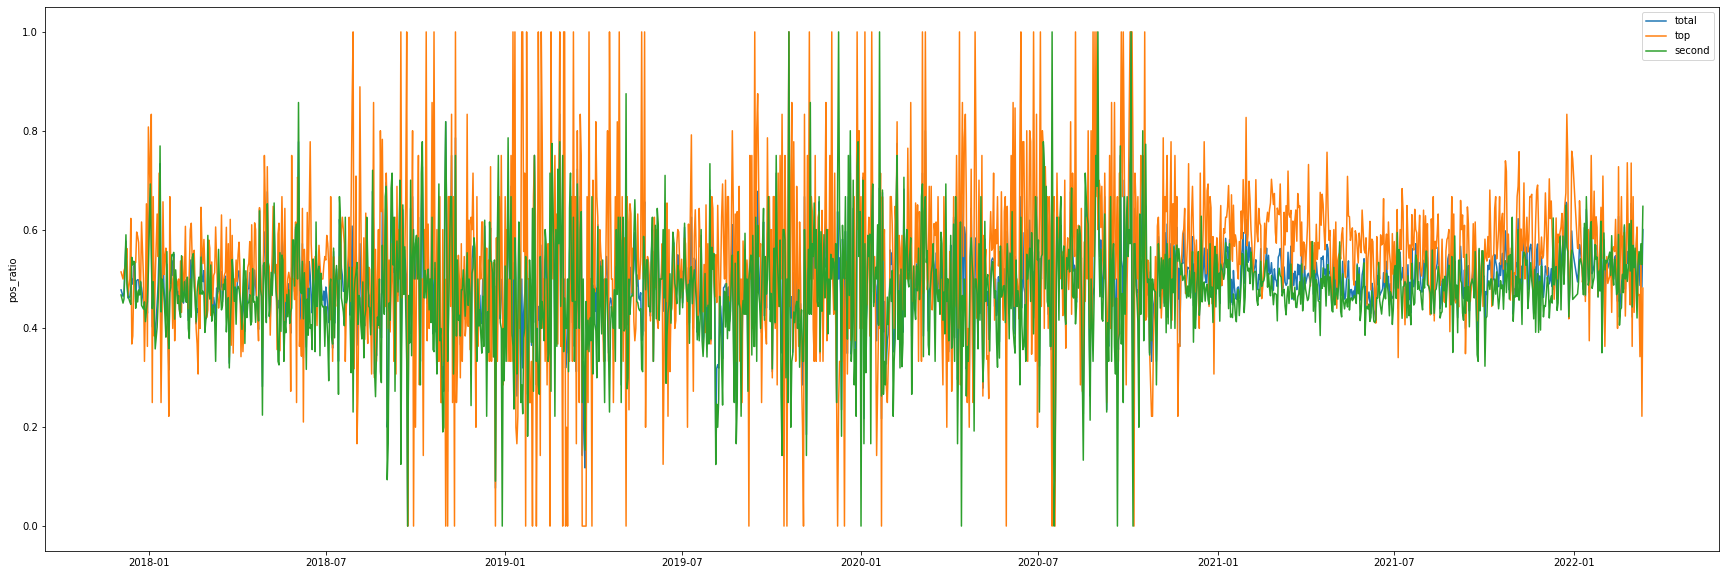

In [ ]:
f, ax = plt.subplots(figsize=(30,10))
ax1 = ax.plot(sent_btc.pos, label ='total')
ax2 = ax.plot(sent_btc_top.pos, label = 'top')
ax3 = ax.plot(sent_btc_second.pos, label = 'second')
plt.legend()
plt.ylabel('pos_ratio')
plt.show()

# Price data load

In [ ]:
!pip install ccxt

import ccxt
import time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.8/271.8 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.4/291.4 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 KB 12.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.

In [ ]:
import time
t = '2017-12-01 09:00:00' #btc 시작
start = int(time.mktime(datetime.strptime(t, '%Y-%m-%d %H:%M:%S').timetuple())*1000)#처음 데이터 가져올 때
def timestamp_to_str(time):  # 타임스탬프 문자열로 변환
    return str(time.year * 100000000 + time.month * 1000000 + time.day * 10000 + time.hour * 100 + time.minute)
days = 86400000
binance = ccxt.binance()
btc_ohlcv = binance.fetch_ohlcv("BTC/USDT", '1d', since = start, limit = 1000)
btc_ohlcv2 = binance.fetch_ohlcv("BTC/USDT", '1d', since = start + days*1000, limit = 1000)
df = pd.DataFrame(btc_ohlcv, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
df2 = pd.DataFrame(btc_ohlcv2, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
df2['datetime'] = pd.to_datetime(df2['datetime'], unit='ms')
df.set_index('datetime', inplace=True)
df2.set_index('datetime', inplace=True)

hist = df.append(df2)
hist.head()

,open,high,low,close,volume
datetime,,,,,
2017-12-02,10775.04,11190.00,10620.00,10890.01,4765.439757
2017-12-03,10902.69,11825.00,10500.00,11165.41,5346.636524
2017-12-04,11165.41,11600.00,10802.00,11579.00,4663.424562
2017-12-05,11571.03,11853.00,11447.68,11699.99,5550.732055
2017-12-06,11699.99,13615.23,11665.58,13550.05,6707.946319


# Relation between sentiment and price

결측치 처리

In [ ]:
def missing_day(day):
  last_day = day.index[-1]
  for i in range(len(day)):
    if day.index[i] == last_day:break
    if day.index[i]  + timedelta(days=1) != day.index[i+1]: #다음 날짜가 없다
      day.loc[day.index[i]  + timedelta(days=1)] = [day.iloc[i,0],day.iloc[i,1],day.iloc[i,2],day.iloc[i,3],day.iloc[i,4]]
  day = day.sort_index()
  return day

In [ ]:
while sent_btc_top.shape[0] >= sent_btc_top.shape[0]:
  print(sent_btc.shape)
  print(sent_btc_top.shape)
  print(sent_btc_second.shape)
  sent_btc = missing_day(sent_btc)
  sent_btc_top = missing_day(sent_btc_top)
  sent_btc_second = missing_day(sent_btc_second)
  print(sent_btc.shape)
  print(sent_btc_top.shape)
  print(sent_btc_second.shape)

(1562, 5)
(1562, 5)
(1562, 5)
(1562, 5)
(1562, 5)
(1562, 5)


In [ ]:
print(sent_btc.shape)
print(hist.shape)
hist = hist.loc[sent_btc.index[0]:sent_btc.index[-1],:] # sent_btc와 start date, end date 통합
print(sent_btc.shape)
print(hist.shape)

(1562, 5)
(1562, 5)
(1562, 5)
(1562, 5)


In [ ]:
sent_btc

,pos,neu,neg,mean,var
day,,,,,
2017-12-03,0.477987,0.232704,0.289308,0.116481,0.155335
2017-12-04,0.477987,0.232704,0.289308,0.116481,0.155335
2017-12-05,0.464912,0.342105,0.192982,0.152574,0.153976
2017-12-06,0.471538,0.275276,0.253186,0.128578,0.170378
2017-12-07,0.471538,0.275276,0.253186,0.128578,0.170378
...,...,...,...,...,...
2022-03-09,0.536913,0.241611,0.221477,0.181752,0.187798
2022-03-10,0.487013,0.194805,0.318182,0.093392,0.219907
2022-03-11,0.568421,0.189474,0.242105,0.189436,0.181592


In [ ]:
hist

,open,high,low,close,volume
datetime,,,,,
2017-12-03,10902.69,11825.00,10500.00,11165.41,5346.636524
2017-12-04,11165.41,11600.00,10802.00,11579.00,4663.424562
2017-12-05,11571.03,11853.00,11447.68,11699.99,5550.732055
2017-12-06,11699.99,13615.23,11665.58,13550.05,6707.946319
2017-12-07,13541.01,16649.96,13050.00,16599.00,7487.065695
...,...,...,...,...,...
2022-03-09,38730.63,42594.06,38656.45,41941.71,67392.587990
2022-03-10,41941.70,42039.63,38539.73,39422.00,71950.256770
2022-03-11,39422.01,40236.26,38223.60,38729.57,59018.764200


In [ ]:
sent_btc

In [ ]:
hist.head()
sent_btc

,pos,neu,neg,mean,var
day,,,,,
2017-12-03,0.477987,0.232704,0.289308,0.116481,0.155335
2017-12-04,0.477987,0.232704,0.289308,0.116481,0.155335
2017-12-05,0.464912,0.342105,0.192982,0.152574,0.153976
2017-12-06,0.471538,0.275276,0.253186,0.128578,0.170378
2017-12-07,0.471538,0.275276,0.253186,0.128578,0.170378
...,...,...,...,...,...
2022-03-13,0.600000,0.115789,0.284211,0.157022,0.189981
2022-03-14,0.600000,0.115789,0.284211,0.157022,0.189981
2022-03-15,0.600000,0.115789,0.284211,0.157022,0.189981


In [ ]:
hist.join(sent_btc) #sent_df의 2022-01-02 ~ 2022-01-04까지 NaN 값

,open,high,low,close,volume,pos,neu,neg,mean,var
datetime,,,,,,,,,,
2017-12-02,10775.04,11190.00,10620.00,10890.01,4765.439757,NaN,NaN,NaN,NaN,NaN
2017-12-03,10902.69,11825.00,10500.00,11165.41,5346.636524,0.477987,0.232704,0.289308,0.116481,0.155335
2017-12-04,11165.41,11600.00,10802.00,11579.00,4663.424562,0.477987,0.232704,0.289308,0.116481,0.155335
2017-12-05,11571.03,11853.00,11447.68,11699.99,5550.732055,0.464912,0.342105,0.192982,0.152574,0.153976
2017-12-06,11699.99,13615.23,11665.58,13550.05,6707.946319,0.471538,0.275276,0.253186,0.128578,0.170378
...,...,...,...,...,...,...,...,...,...,...
2022-03-10,41941.70,42039.63,38539.73,39422.00,71950.256770,0.487013,0.194805,0.318182,0.093392,0.219907
2022-03-11,39422.01,40236.26,38223.60,38729.57,59018.764200,0.568421,0.189474,0.242105,0.189436,0.181592
2022-03-12,38729.57,39486.71,38660.52,38807.36,24034.364320,0.483333,0.183333,0.333333,0.117295,0.173147


## Visualization

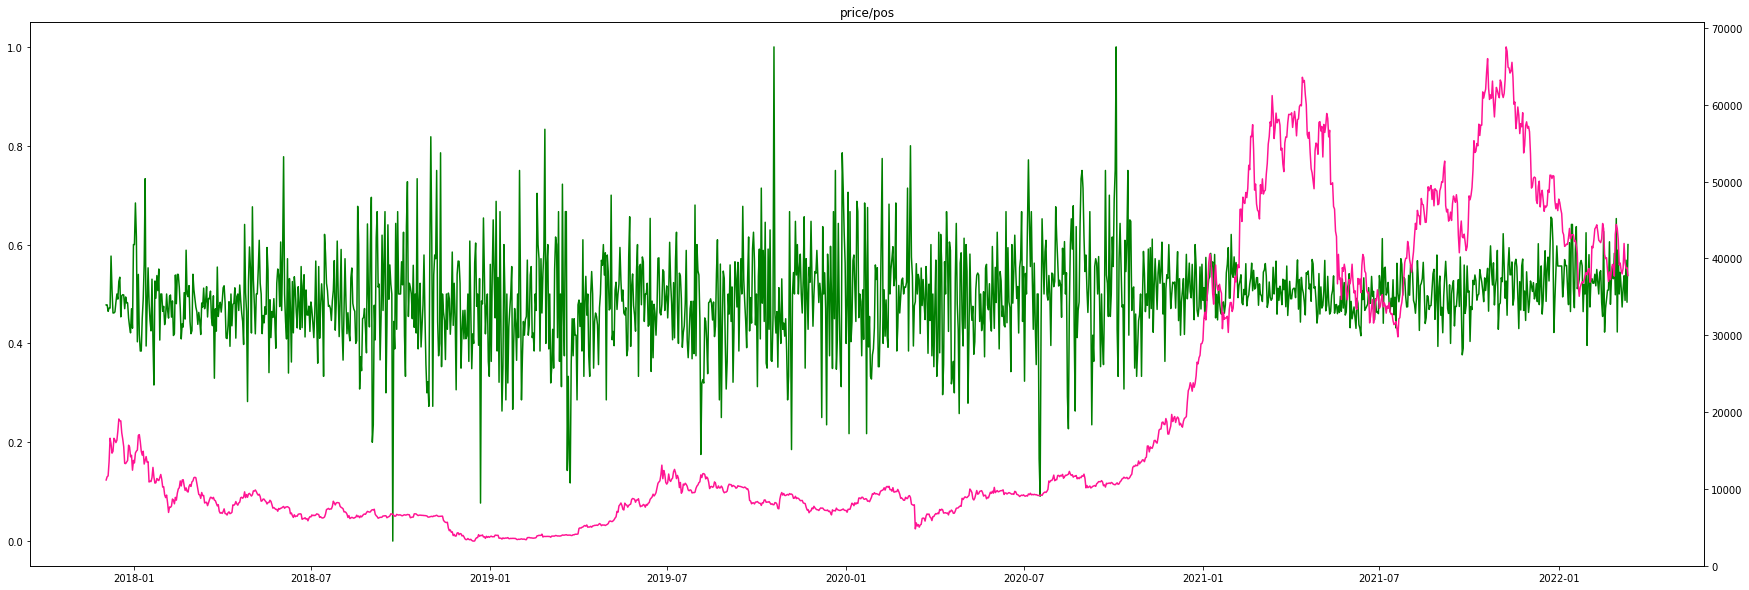

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,10))
x = sent_btc.index
y1 = sent_btc.pos
y2 = hist['close']
ax1.plot(x, y1, color='green')

ax2 = ax1.twinx()
ax2.plot(x, y2, color='deeppink')
plt.title('price/pos')
plt.show()

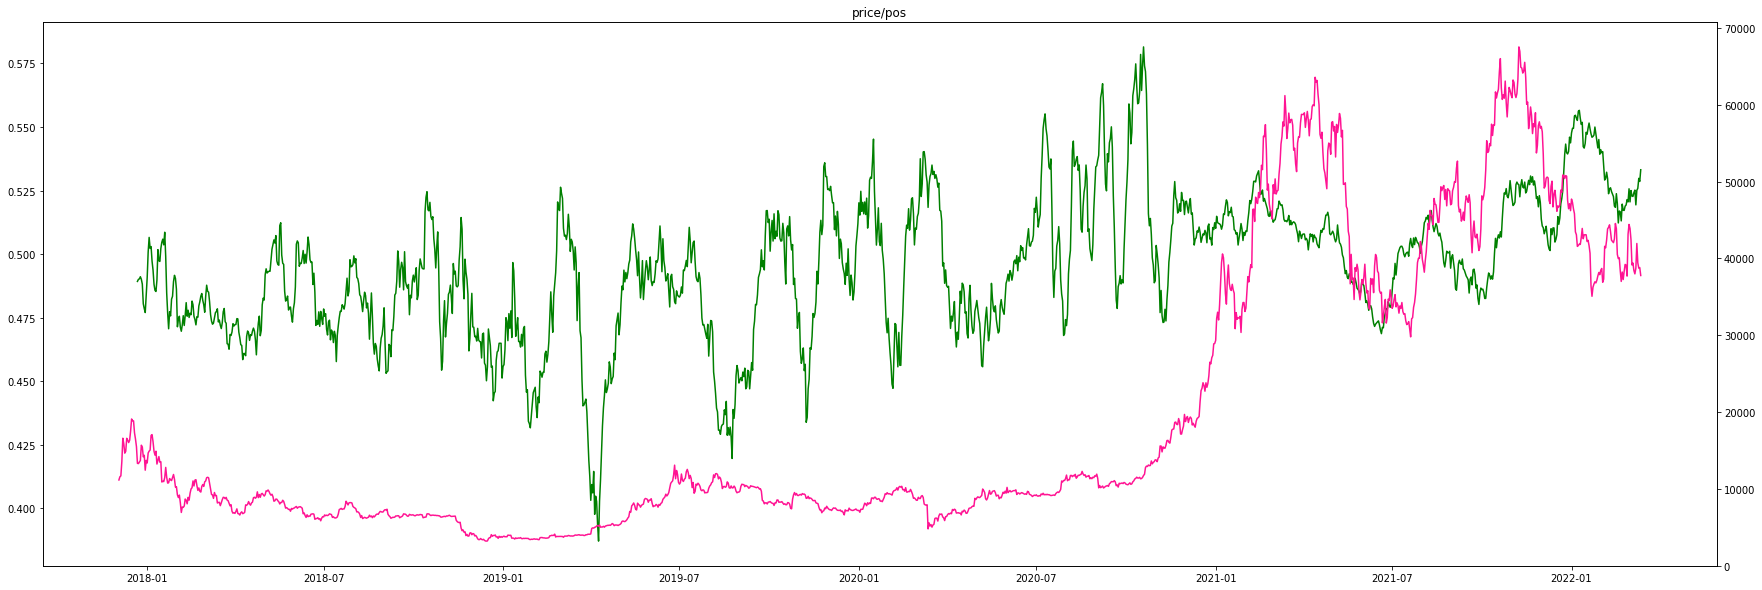

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,10))
x = sent_btc.index
y1 = sent_btc.pos.rolling(window=20, min_periods=20).mean()
y2 = hist['close']
ax1.plot(x, y1, color='green')

ax2 = ax1.twinx()
ax2.plot(x, y2, color='deeppink')
plt.title('price/pos')
plt.show()

## Correlation

In [ ]:
sent_btc['mean']

day
2017-12-03    0.116481
2017-12-04    0.116481
2017-12-05    0.152574
2017-12-06    0.128578
2017-12-07    0.128578
                ...   
2022-03-09    0.181752
2022-03-10    0.093392
2022-03-11    0.189436
2022-03-12    0.117295
2022-03-13    0.157022
Name: mean, Length: 1562, dtype: float64

In [ ]:
import numpy as np
#상관계수

def correlation(day, price):
  print('pos',np.corrcoef(day['pos'], price['close'])[0,1])
  print('neg',np.corrcoef(day['neg'], price['close'])[0,1])
  # print('mean',np.corrcoef(day['mean'], price['close'])[0,1])
  print('긍정MA20', np.corrcoef(day.pos.rolling(window=20, min_periods=1).mean(), price['close'])[0,1])
  print('부정MA20', np.corrcoef(day.neg.rolling(window=20, min_periods=1).mean(), price['close'])[0,1])
  print('meanMA20', np.corrcoef(day['mean'].rolling(window=20, min_periods=1).mean(), price['close'])[0,1])

In [ ]:
sent_btc = sent_btc.fillna(0)

In [ ]:
correlation(sent_btc, hist)
correlation(sent_btc_top, hist)
correlation(sent_btc_second, hist)

pos 0.12473051786508375
neg -0.02919545285149965
긍정MA20 0.41130271677869945
부정MA20 -0.10090396826563945
meanMA20 0.3623070479011787
pos 0.13349837595847522
neg -0.0606516904296515
긍정MA20 0.47328725703946123
부정MA20 -0.22339646734627167
meanMA20 0.4391975461408712
pos 0.06542909444455677
neg 0.02547571903407211
긍정MA20 0.23346468356421485
부정MA20 0.07814002007746572
meanMA20 0.16895927596988328


In [ ]:
# bitcoin_stats = tfdv.generate_statistics_from_dataframe(day)
# crypto_stats = tfdv.generate_statistics_from_dataframe(df2)

In [ ]:
# # Compare training with evaluation
# tfdv.visualize_statistics(
#     lhs_statistics=bitcoin_stats, 
#     rhs_statistics=crypto_stats, 
#     lhs_name='bitcoin_sets', 
#     rhs_name='crypto_sets'
# )

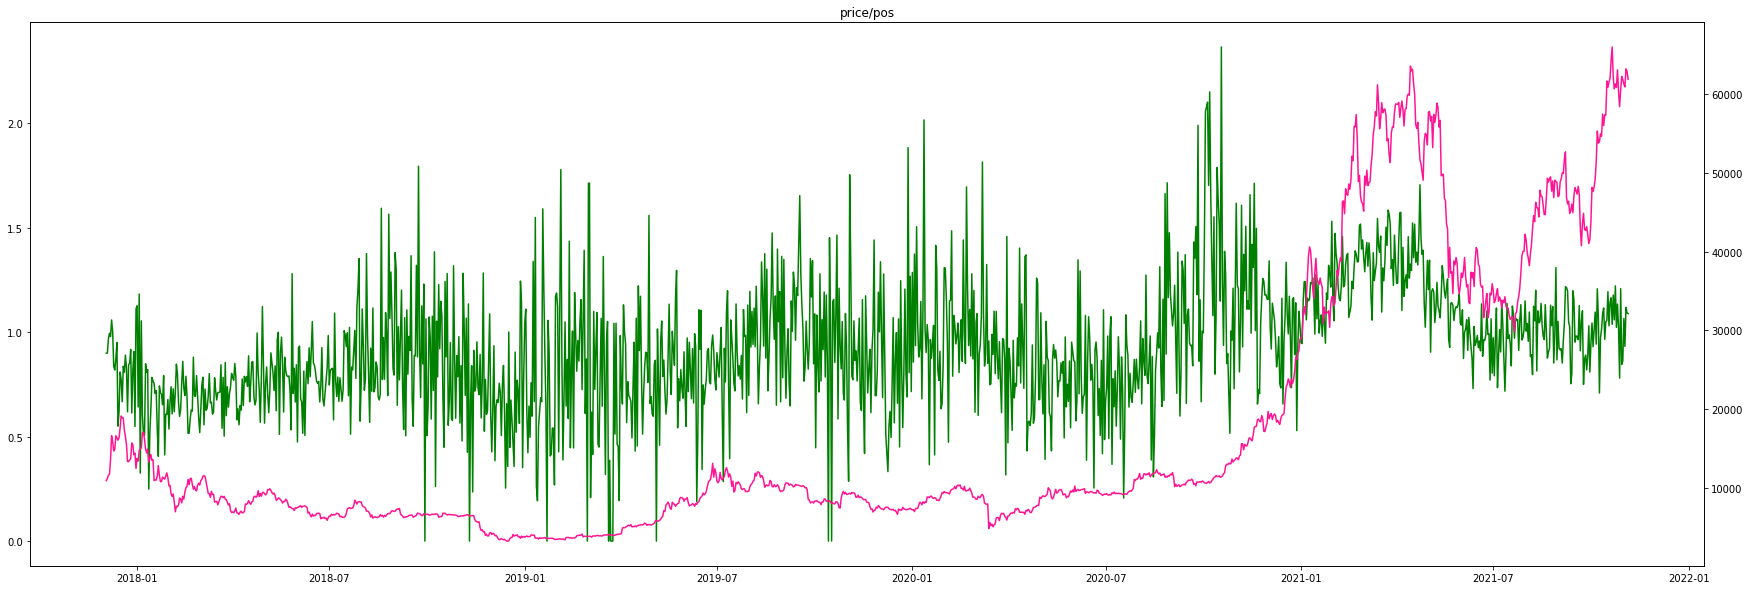

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,10))
x = day.index
y1 = day.pos/(day.neg*2).rolling(window=60, min_periods=1).mean()
y2 = price['close']
ax1.plot(x, y1, color='green')

ax2 = ax1.twinx()
ax2.plot(x, y2, color='deeppink')
plt.title('price/neg')
plt.show()

In [ ]:
print('긍정',np.corrcoef(day['pos'], price['fluct'])[0,1])
print('중립',np.corrcoef(day['neu'], price['fluct'])[0,1])
print('부정',np.corrcoef(day['neg'], price['fluct'])[0,1])
print('긍정-부정*2',np.corrcoef(day['pos-neg'], price['fluct'])[0,1])
print('긍정MA5', np.corrcoef(day.pos.rolling(window=5, min_periods=1).mean(), price['fluct'])[0,1])
print('부정MA5', np.corrcoef(day.neg.rolling(window=5, min_periods=1).mean(), price['fluct'])[0,1])
print('긍정MA20', np.corrcoef(day.pos.rolling(window=20, min_periods=1).mean(), price['fluct'])[0,1])
print('부정MA20', np.corrcoef(day.neg.rolling(window=20, min_periods=1).mean(), price['fluct'])[0,1])
print('긍정MA60', np.corrcoef(day.pos.rolling(window=60, min_periods=1).mean(), price['fluct'])[0,1])
print('부정MA60', np.corrcoef(day.neg.rolling(window=60, min_periods=1).mean(), price['fluct'])[0,1])
print('긍정MA200', np.corrcoef(day.pos.rolling(window=200, min_periods=1).mean(), price['fluct'])[0,1])
print('부정MA200', np.corrcoef(day.neg.rolling(window=200, min_periods=1).mean(), price['fluct'])[0,1])

긍정 -0.012327952601845112
중립 0.01771697181008595
부정 -0.0017835128562533715
긍정-부정*2 -0.0035734517094258254
긍정MA5 0.02960061716382623
부정MA5 -0.044214006116125096
긍정MA20 0.014110661806779631
부정MA20 -0.04084994767024763
긍정MA60 0.022855958125468274
부정MA60 -0.025806461402768006
긍정MA200 0.03117419475866923
부정MA200 -0.030159614305987313
